In [33]:

import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta, timezone
from zoneinfo import ZoneInfo
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### Getting Data and Process Date Columns

In [37]:
# query btc price data
db_file = "Data/crypto.db"
conn = sqlite3.connect(db_file)
query = "SELECT * FROM btc_hourly order by time" # contains btc hourly data from 2014
df = pd.read_sql(query, conn)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90693 entries, 0 to 90692
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        90693 non-null  int64  
 1   utc_dt      90693 non-null  object 
 2   nyc_dt      90693 non-null  object 
 3   high        90693 non-null  float64
 4   low         90693 non-null  float64
 5   open        90693 non-null  float64
 6   close       90693 non-null  float64
 7   volumefrom  90693 non-null  float64
 8   volumeto    90693 non-null  float64
 9   avg         90693 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 6.9+ MB
None


In [38]:
df['utc_dt'] = pd.to_datetime(df['utc_dt'])
df['nyc_dt'] = df['utc_dt'].apply(lambda x: x.astimezone(ZoneInfo("America/New_York")))

df['year'] = df['utc_dt'].dt.year
df['month'] = df['utc_dt'].dt.month
df['day'] = df['utc_dt'].dt.day
df['weekday'] = df['utc_dt'].dt.weekday # Monday=0, Sunday=6
df['hour'] = df['utc_dt'].dt.hour

# outlier for timestamp 1595300400, remove this record
df = df[df['time']!=1595300400]

#### Visualizing Pricing Trend

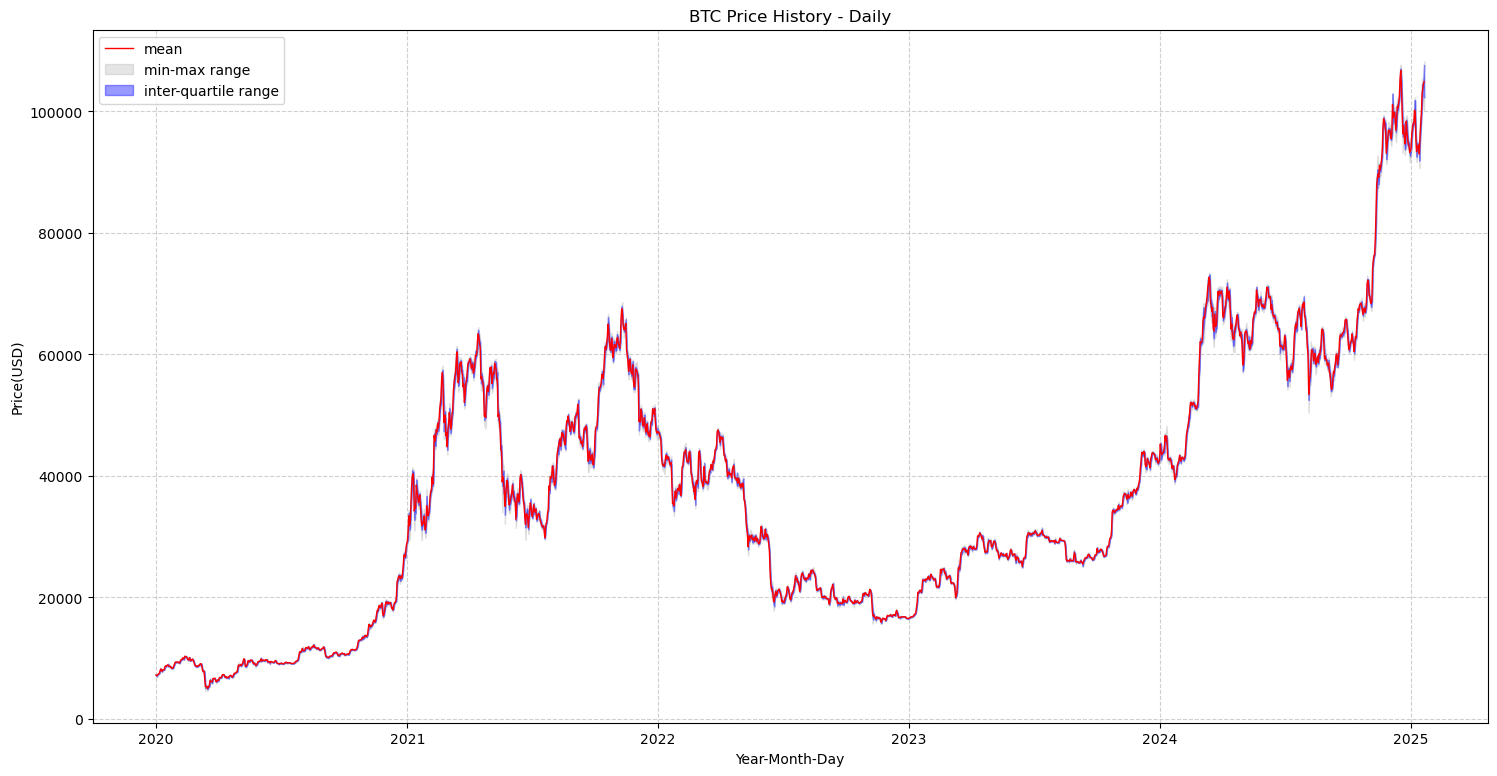

In [57]:
#-------------------- plot mean, min/max/25%/75%
#-----------by year/month/day
res = df.groupby(['year','month','day'])['avg'].describe().reset_index()
res['ymd'] = pd.to_datetime(res['year'].astype(str) + '-' + res['month'].astype(str) + '-' + res['day'].astype(str))

# only visualize for 2020 and later
res = res[res['year']>=2020]

plt.figure(figsize=(18,9))

# mean
plt.plot(res['ymd'],res['mean'],'r-',label='mean',linewidth=1)
# range
plt.fill_between(res['ymd'], res['min'], res['max'], color='grey', alpha=0.2, label='min-max range')
plt.fill_between(res['ymd'], res['25%'], res['75%'], color='blue', alpha=0.4, label='inter-quartile range')

plt.title('BTC Price History - Daily')
plt.xlabel('Year-Month-Day')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

plt.show()

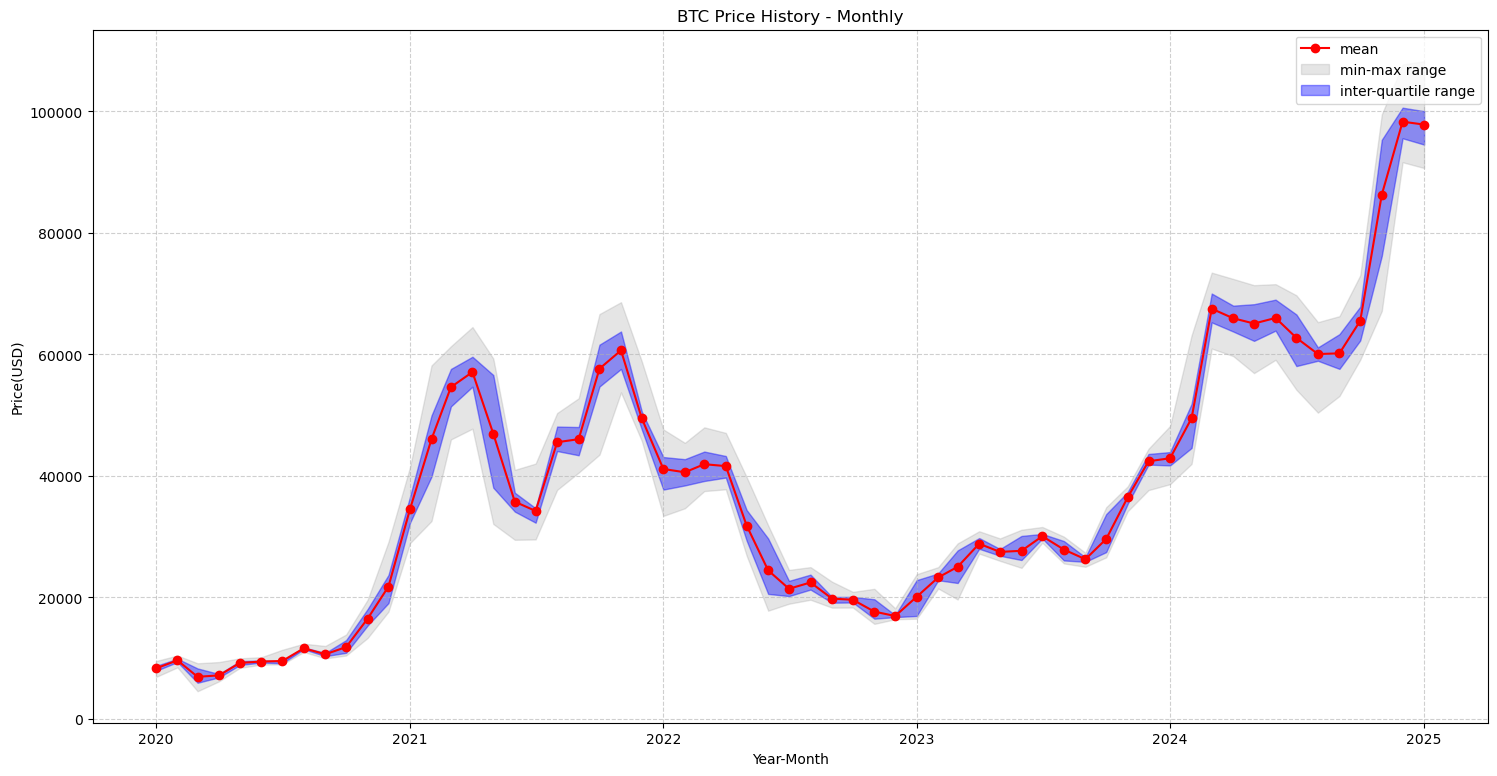

In [58]:
#-------------------- plot mean, min/max/25%/75%
#-----------by year/month
res = df.groupby(['year','month'])['avg'].describe().reset_index()
res['ym'] = pd.to_datetime(res['year'].astype(str) + '-' + res['month'].astype(str) + '-01')
res = res[res['year']>=2020]

plt.figure(figsize=(18,9))

# mean
plt.plot(res['ym'],res['mean'],'ro-',label='mean')
# range
plt.fill_between(res['ym'], res['min'], res['max'], color='grey', alpha=0.2, label='min-max range')
plt.fill_between(res['ym'], res['25%'], res['75%'], color='blue', alpha=0.4, label='inter-quartile range')

plt.title('BTC Price History - Monthly')
plt.xlabel('Year-Month')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

plt.show()

#### A Glimpse at Price Fluctuation within a Month

BTC price fluctuation is more turbulent after 2024:
- It's generally safe to expect a range of 6*std within a month, which is roughly $20,000, or 25% to 30% of its highest price of the month.
- High volatility is rarely seen to last for several months - it alternates from month to month.

            ym           std    std_pct
64  2020-01-01    635.403454   7.625136
65  2020-02-01    448.435912   4.645861
66  2020-03-01   1345.754214  19.378611
67  2020-04-01    506.592236   7.050315
68  2020-05-01    372.899480   4.038123
69  2020-06-01    235.246055   2.486670
70  2020-07-01    650.458862   6.812831
71  2020-08-01    242.044788   2.080330
72  2020-09-01    407.742879   3.824468
73  2020-10-01   1058.079720   8.939665
74  2020-11-01   1691.266872  10.237619
75  2020-12-01   3290.847470  15.094186
76  2021-01-01   2949.802169   8.541579
77  2021-02-01   6335.439545  13.754716
78  2021-03-01   3805.046281   6.965149
79  2021-04-01   3703.400810   6.485463
80  2021-05-01   8960.132494  19.083462
81  2021-06-01   2324.580860   6.499306
82  2021-07-01   2907.932796   8.493002
83  2021-08-01   3279.210222   7.198388
84  2021-09-01   2931.777452   6.365492
85  2021-10-01   5268.702839   9.137713
86  2021-11-01   3649.211257   6.014529
87  2021-12-01   2769.794409   5.598962


<Figure size 1800x900 with 0 Axes>

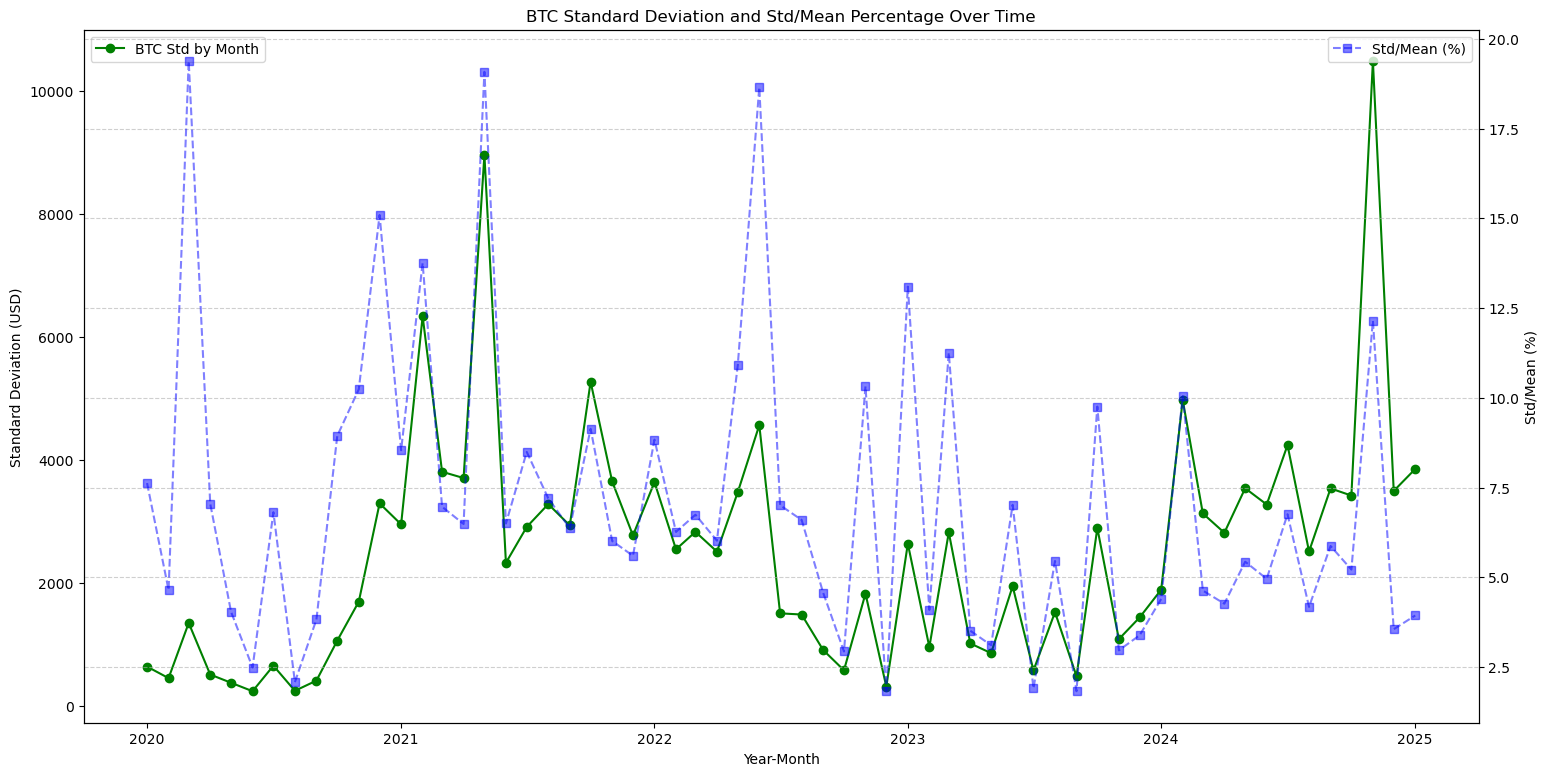

In [62]:
# plot std
#-----------by year/month
res = df.groupby(['year','month'])['avg'].describe().reset_index()
res['ym'] = pd.to_datetime(res['year'].astype(str) + '-' + res['month'].astype(str) + '-01')
res = res[res['year']>=2020]

plt.figure(figsize=(18,9))

# std/mean
res['std_pct'] = res['std']*100/res['mean']
print(res[['ym','std','std_pct']])

# plot with 2 axis
fig, ax1 = plt.subplots(figsize=(18,9))

ax1.plot(res['ym'],res['std'],'go-',label='BTC Std by Month')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Standard Deviation (USD)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(res['ym'],res['std_pct'],'bs--',label='Std/Mean (%)',alpha=0.5)
ax2.set_ylabel('Std/Mean (%)')
ax2.legend(loc='upper right')

plt.title('BTC Standard Deviation and Std/Mean Percentage Over Time')
plt.grid(linestyle='--', alpha=0.6)

#### Hourly Data Examination

Surprisingly, the ratio between Open/Close Range and High/Low Range is pretty much evenly distributed (<0.8), which means the open/close prices indicate very little about high/low prices.

count    9260.000000
mean        0.016966
std         0.525211
min        -0.999982
25%        -0.435998
50%         0.025051
75%         0.465394
max         0.999981
Name: ratio, dtype: float64


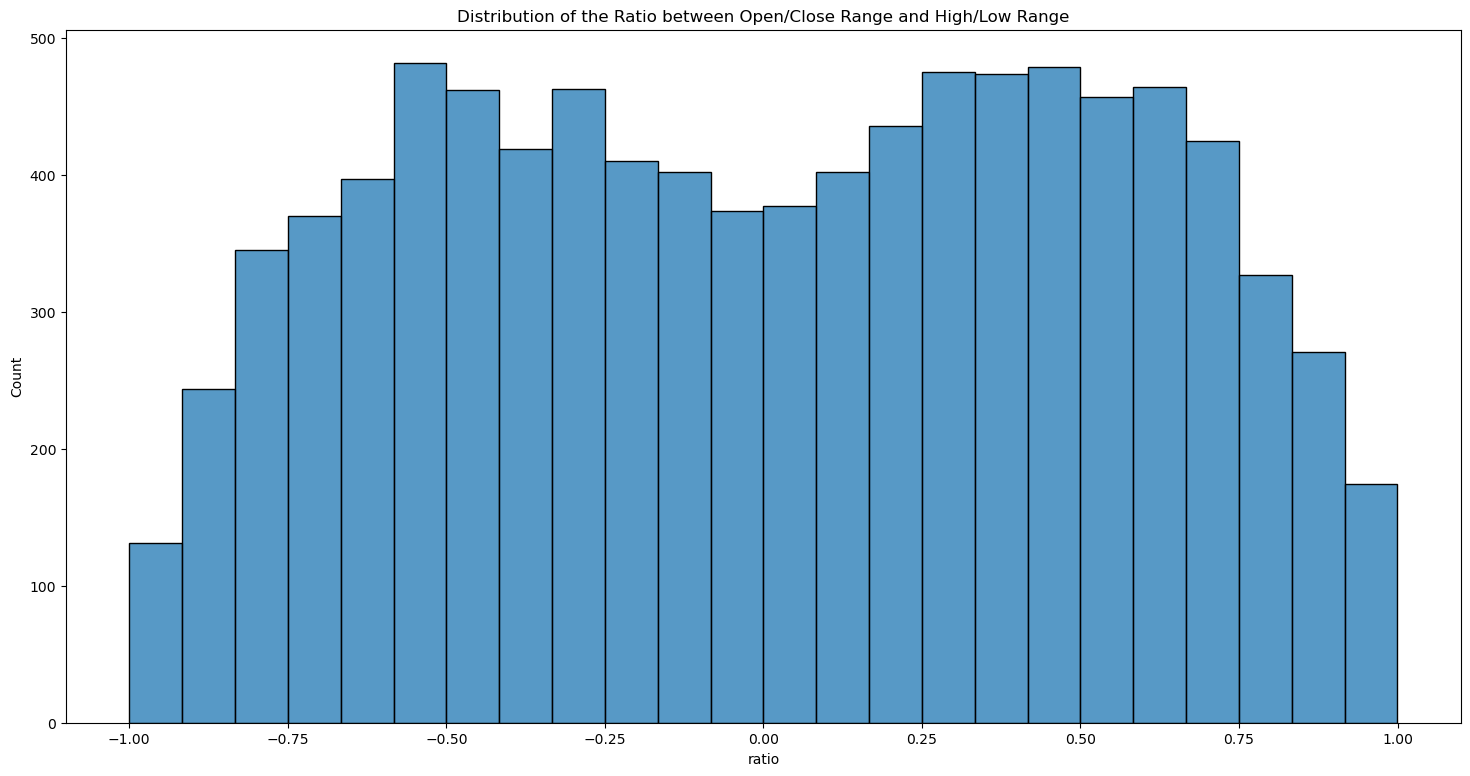

In [66]:
# hourly openclose/minmax ratio distribution
df['minmax_range'] = df['high'] - df['low']
df['openclose_range'] = df['close'] - df['open']
df['ratio'] = df['openclose_range']/df['minmax_range']

df24 = df[df['year']>=2024] # 

print(df24['ratio'].describe())

plt.figure(figsize=(18,9))
sns.histplot(x=df24['ratio'])
plt.title('Distribution of the Ratio between Open/Close Range and High/Low Range')
plt.show()

BTC price fluctuation within an hour can be horrible - keep below numbers in mind when dealing contract
- BTC price can rise/drop up to 8.75% of its average trading price during an hour!
- Generally (in 95% of cases), BTC price change within an hour is less than 1280, or roughly 2%

0.00      24.6400
0.05     129.6995
0.10     165.1270
0.15     193.8260
0.20     220.5320
0.25     248.0600
0.30     273.0770
0.35     298.4665
0.40     326.8680
0.45     354.1495
0.50     385.0600
0.55     420.7145
0.60     462.8120
0.65     507.3030
0.70     560.7570
0.75     625.4350
0.80     708.4700
0.85     809.0085
0.90     974.8310
0.95    1280.4760
1.00    7388.2700
Name: minmax_range, dtype: float64


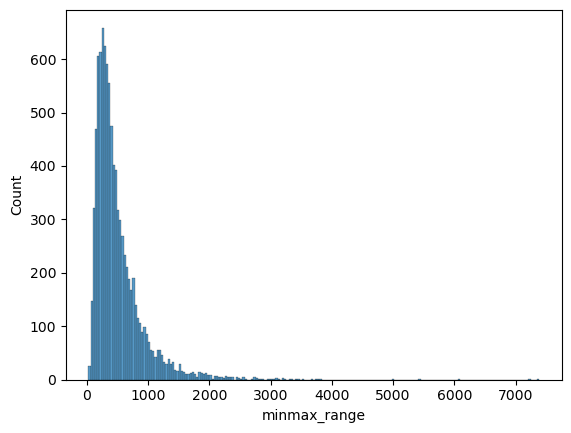

In [67]:
# minmax range distribution
print(df24['minmax_range'].quantile([x/20 for x in range(21)]))
sns.histplot(x=range_df['minmax_range'])
plt.show()

0.00    0.000573
0.05    0.002169
0.10    0.002719
0.15    0.003142
0.20    0.003544
0.25    0.003899
0.30    0.004241
0.35    0.004599
0.40    0.005007
0.45    0.005379
0.50    0.005814
0.55    0.006310
0.60    0.006864
0.65    0.007468
0.70    0.008258
0.75    0.009183
0.80    0.010367
0.85    0.011769
0.90    0.013978
0.95    0.018119
1.00    0.087875
dtype: float64


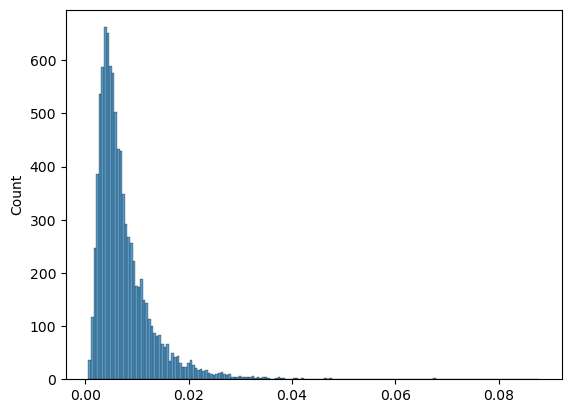

In [68]:
print((df24['minmax_range']/df24['avg']).quantile([x/20 for x in range(21)]))
sns.histplot(x=df24['minmax_range']/df['avg'])
plt.show()

There is high correlation (0.46) between the price change and the number of BTC traded - volume traded typically means higher price change.

In [72]:
# ABS trade volume change vs. price change after 2024
df24['abs_price_change'] = np.abs(df24['avg'] - df24['avg'].shift(1)) / df24['avg'].shift(1)
df24['abs_volume_change'] = np.abs(df24['volumefrom'] - df24['volumefrom'].shift(1))/ df24['avg'].shift(1)

# correlation between price change and volume traded
print(df24['abs_price_change'].corr(df24['abs_volume_change'])) # from hour to hour
print(np.abs(df24['openclose_range']).corr(df24['volumefrom'])) # within an hour

0.46370157427293485
0.5757557144319756


C:\Users\elisa\AppData\Local\Temp\ipykernel_39676\3507495070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['abs_price_change'] = np.abs(df24['avg'] - df24['avg'].shift(1)) / df24['avg'].shift(1)
C:\Users\elisa\AppData\Local\Temp\ipykernel_39676\3507495070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['abs_volume_change'] = np.abs(df24['volumefrom'] - df24['volumefrom'].shift(1))/ df24['avg'].shift(1)


In [87]:
# calculate price change within an hour
df24['price_pct_change'] = df24['openclose_range']*100/df24['open']
# print(df24['price_pct_change'].describe())

# Define surges and drops based on thresholds
price_surge_threshold = 0.5  
price_drop_threshold = -0.5 

df24['price_surge'] = df24['price_pct_change'] > price_surge_threshold
df24['price_drop'] = df24['price_pct_change'] < price_drop_threshold

C:\Users\elisa\AppData\Local\Temp\ipykernel_39676\2374984461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['price_pct_change'] = df24['openclose_range']*100/df24['open']
C:\Users\elisa\AppData\Local\Temp\ipykernel_39676\2374984461.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['price_surge'] = df24['price_pct_change'] > price_surge_threshold
C:\Users\elisa\AppData\Local\Temp\ipykernel_39676\2374984461.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [88]:
# Define a helper function to calculate lasting periods
def calculate_periods(series):
    periods = []
    current_length = 0
    for value in series:
        if value:
            current_length += 1
        else:
            if current_length > 0:
                periods.append(current_length)
            current_length = 0
    if current_length > 0:
        periods.append(current_length)
    return periods

# Calculate lasting periods for price surges and drops
price_surge_periods = calculate_periods(df24['price_surge'])
price_drop_periods = calculate_periods(df24['price_drop'])

print(pd.Series(price_surge_periods).value_counts())
print(pd.Series(price_drop_periods).value_counts())

print("Price Surge Periods Statistics:", np.mean(price_surge_periods), np.std(price_surge_periods))
print("Price Drop Periods Statistics:", np.mean(price_drop_periods), np.std(price_drop_periods))

1    760
2    124
3     30
5      2
4      1
dtype: int64
1    699
2    120
3     19
4      4
dtype: int64
Price Surge Periods Statistics: 1.2126499454743729 0.5153407366438237
Price Drop Periods Statistics: 1.2019002375296912 0.48453146016608656
